In [143]:
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats

library(tidyverse) # metapackage with lots of helpful functions

## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

## Reading in files

# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 

list.files(path = "../input")

## Saving data

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.

[1] "gender_submission.csv" "test.csv"              "train.csv"

In [144]:
library("dplyr") 
library("mice")  
library("ggplot2")  
library("caret")  
library("ranger")  
library("stringr")  
library("data.table") 
library("gridExtra")
library("ggthemes")
library("reshape2")
library("Amelia")  
library("scales")  
library("car") 
library("ROCR") 
library("e1071")  
library("rpart") 
library("rpart.plot")  
library("randomForest")  
library("caTools")

In [145]:
train <- read.csv('../input/train.csv', stringsAsFactors = F)
test  <- read.csv('../input/test.csv', stringsAsFactors = F)

full_test  <- bind_rows(train, test) # bind training & test data


In [146]:
glimpse(full_test)

Observations: 1,309
Variables: 12
$ PassengerId <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17…
$ Survived    <int> 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, …
$ Pclass      <int> 3, 1, 3, 1, 3, 3, 1, 3, 3, 2, 3, 1, 3, 3, 3, 2, 3, 2, 3, …
$ Name        <chr> "Braund, Mr. Owen Harris", "Cumings, Mrs. John Bradley (F…
$ Sex         <chr> "male", "female", "female", "female", "male", "male", "ma…
$ Age         <dbl> 22, 38, 26, 35, 35, NA, 54, 2, 27, 14, 4, 58, 20, 39, 14,…
$ SibSp       <int> 1, 1, 0, 1, 0, 0, 0, 3, 0, 1, 1, 0, 0, 1, 0, 0, 4, 0, 1, …
$ Parch       <int> 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 5, 0, 0, 1, 0, 0, …
$ Ticket      <chr> "A/5 21171", "PC 17599", "STON/O2. 3101282", "113803", "3…
$ Fare        <dbl> 7.2500, 71.2833, 7.9250, 53.1000, 8.0500, 8.4583, 51.8625…
$ Cabin       <chr> "", "C85", "", "C123", "", "", "E46", "", "", "", "G6", "…
$ Embarked    <chr> "S", "C", "S", "S", "S", "Q", "S", "S", "S", "C", "S", "S…


In [147]:
colSums(is.na(full_test))

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0         263 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           1           0           0

**Age**

First er start off by looking at the distribution of age, by using geom_histogram and ggplot :

In [148]:
colSums(full_test=='')

PassengerId    Survived      Pclass        Name         Sex         Age 
          0          NA           0           0           0          NA 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0          NA        1014           2

In [149]:
table(full_test$Embarked)


      C   Q   S 
  2 270 123 914 

In [150]:
full_test$Embarked[full_test$Embarked==""]="S"
table(full_test$Embarked)


  C   Q   S 
270 123 916 

In [151]:
apply(full_test,2, function(x) length(unique(x)))

PassengerId    Survived      Pclass        Name         Sex         Age 
       1309           3           3        1307           2          99 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          7           8         929         282         187           3

In [220]:
cols=c("Survived","Pclass","Sex","Embarked")
for (i in cols){
  full_test[,i]=as.factor(full_test[,i])
}

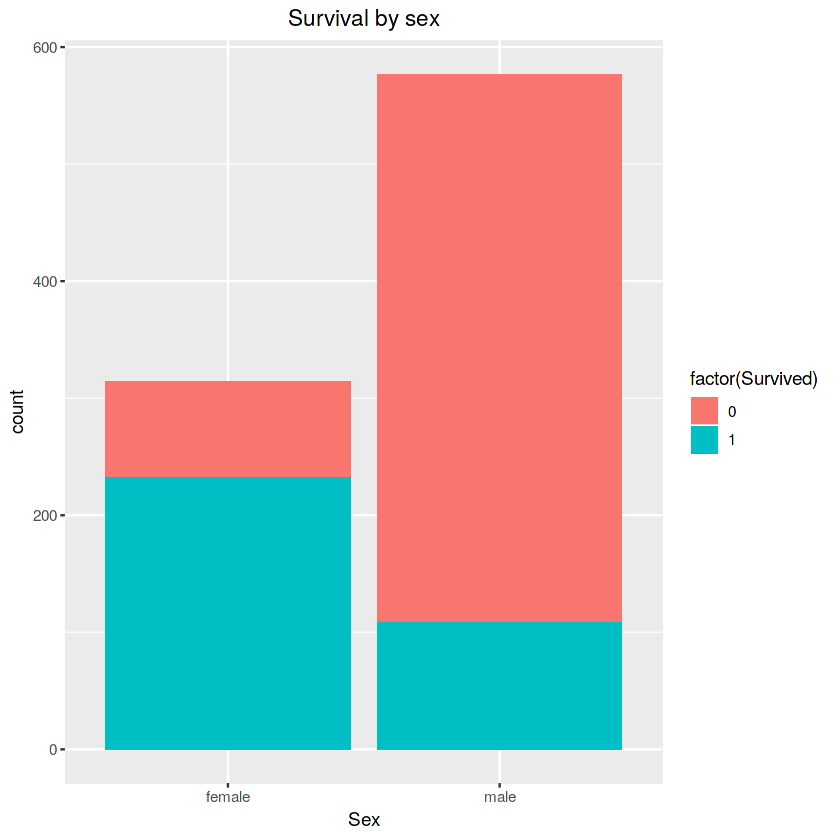

In [153]:
ggplot(full_test[1:891,], aes(x = Sex))+
  geom_bar(aes(fill = factor(Survived)))+
  labs(x = "Sex")+
  ggtitle("Survival by sex")+
  theme(plot.title = element_text(hjust = 0.5))

**Families**

Looking at the Parch and SibSp columns (Parents/Children and Sibling/Spouses), we have some data on family sizes. Since each row is an observation of a single person, we know how many family members are present on the Titanic. Let’s see if that tells us something usefull for our prediction.

In [154]:
full_test$FamilySize <-full_test$SibSp + full_test$Parch + 1

full_test$FamilySized[full_test$FamilySize == 1]   <- 'Single'
full_test$FamilySized[full_test$FamilySize < 5 & full_test$FamilySize >= 2]   <- 'Small'
full_test$FamilySized[full_test$FamilySize >= 5]   <- 'Big'

full_test$FamilySized=as.factor(full_test$FamilySized)

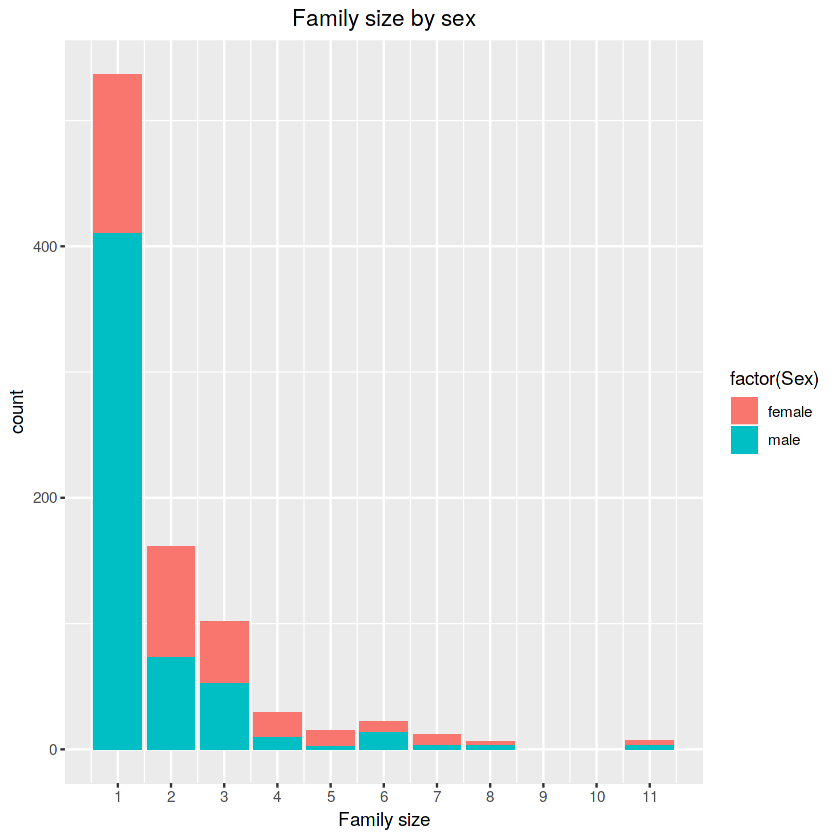

In [155]:
ggplot(full_test[1:891,], aes(x = FamilySize))+
  geom_bar(aes(fill = factor(Sex))) + 
  scale_x_continuous(breaks = c(1:15))+
  labs(x = "Family size")+
  ggtitle("Family size by sex")+
  theme(plot.title = element_text(hjust = 0.5))

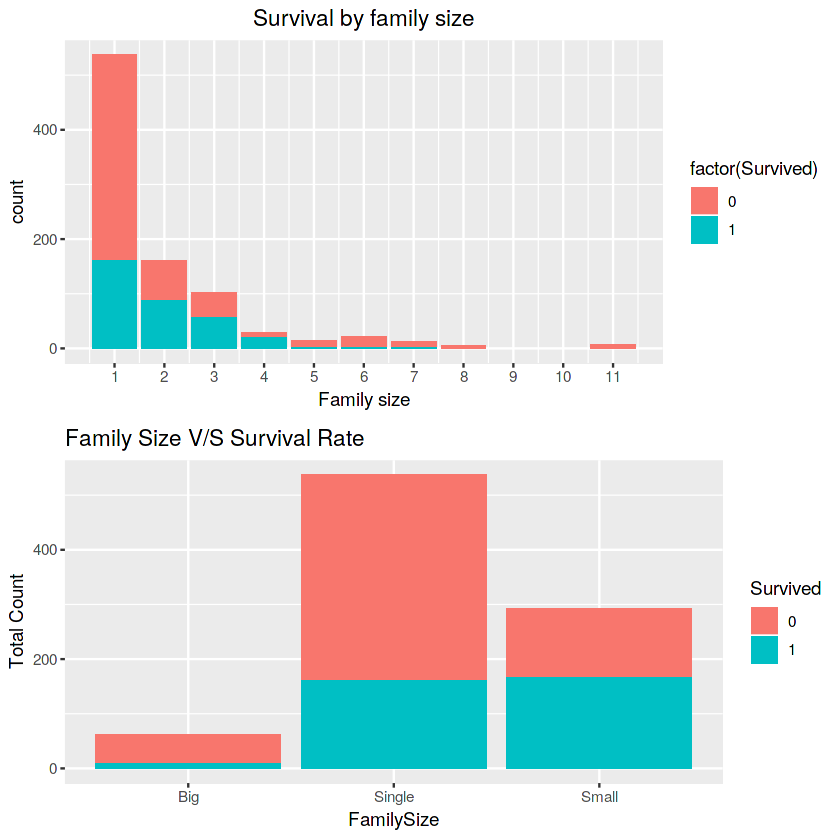

In [156]:
P1 <- ggplot(full_test[1:891,], aes(x = FamilySize))+
  geom_bar(aes(fill = factor(Survived))) + 
  scale_x_continuous(breaks = c(1:15))+
  labs(x = "Family size")+
  ggtitle("Survival by family size")+
  theme(plot.title = element_text(hjust = 0.5))


P2 <- ggplot(full_test[1:891,],aes(x = FamilySized,fill=factor(Survived))) +
  geom_bar() +
  ggtitle("Family Size V/S Survival Rate") +
  xlab("FamilySize") +
  ylab("Total Count") +
  labs(fill = "Survived")

grid.arrange(P1, P2, nrow =2)


In [157]:
full_test$Title <- gsub('(.*, )|(\\..*)', '', full_test$Name) 
str(full_test)

'data.frame':	1309 obs. of  15 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ FamilySize : num  2 2 1 2 1 1 1 5 3 2 ...
 $ FamilySized: Factor w/ 3 levels "Big","Single",..: 3 3 2 3 2 2 2 1 3 3 ...
 $ Title 

In [158]:
table(full_test$Title) 


        Capt          Col          Don         Dona           Dr     Jonkheer 
           1            4            1            1            8            1 
        Lady        Major       Master         Miss         Mlle          Mme 
           1            2           61          260            2            1 
          Mr          Mrs           Ms          Rev          Sir the Countess 
         757          197            2            8            1            1 

In [159]:
titles <- table(full_test$Title)
rare_titles <- rownames(titles[titles < 10])
full_test$Title[full_test$Title %in% rare_titles] <- "Rare title"
full_test$Title[full_test$Title == "Mlle"] <- "Miss"
full_test$Title[full_test$Title == "Ms"] <- "Miss"
full_test$Title[full_test$Title == "Mme"]<- "Mrs"


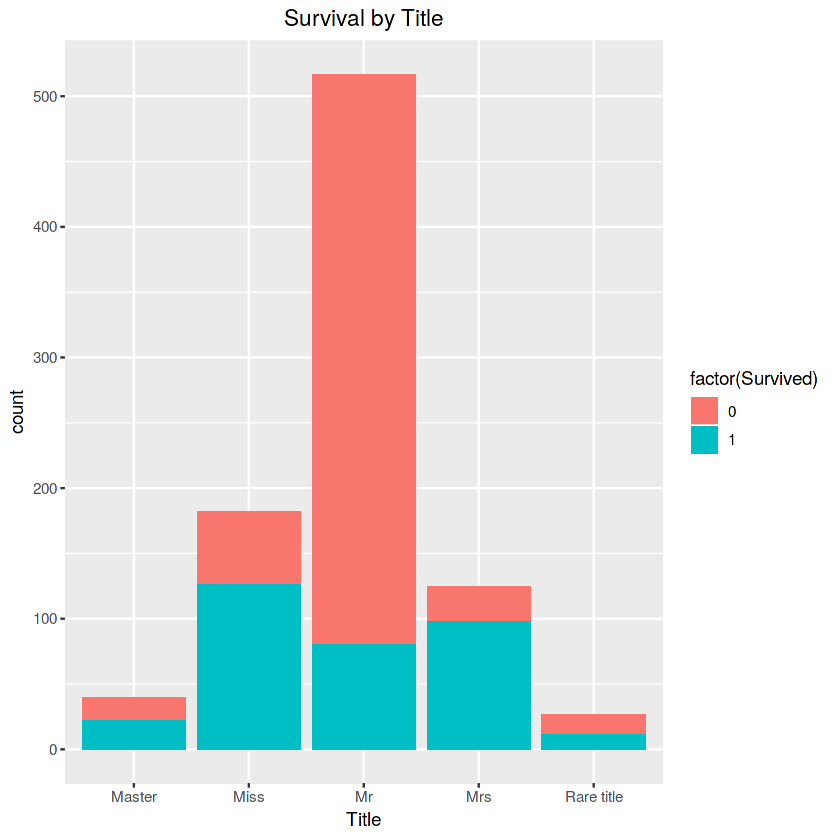

In [160]:
ggplot(full_test[1:891,], aes(x = Title))+
  geom_bar(stat = "count", aes(fill = factor(Survived))) + 
  labs(x = "Title")+
  ggtitle("Survival by Title")+
  theme(plot.title = element_text(hjust = 0.5))

In [161]:
ticket.unique <- rep(0, nrow(full_test))
tickets <- unique(full_test$Ticket)

for (i in 1:length(tickets)) {
  current.ticket <- tickets[i]
  party.indexes <- which(full_test$Ticket == current.ticket)
  
  
  for (k in 1:length(party.indexes)) {
    ticket.unique[party.indexes[k]] <- length(party.indexes)
  }
}

full_test$ticket.unique <- ticket.unique

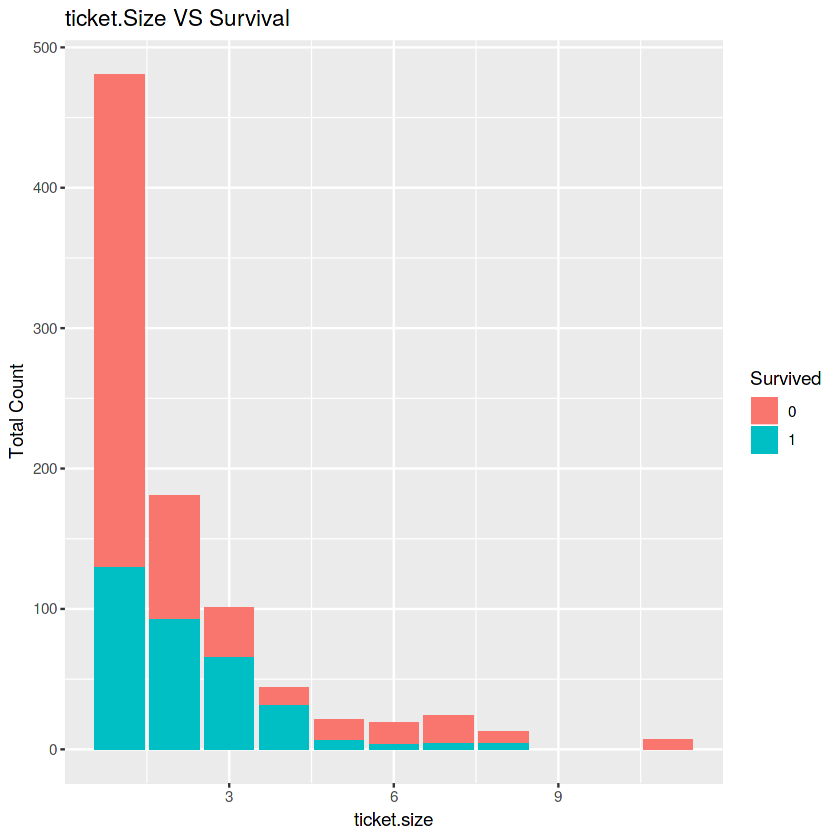

In [162]:
ggplot(full_test[1:891,],aes(x = ticket.unique,fill=factor(Survived))) +
  geom_bar() +
  ggtitle("ticket.Size VS Survival")+
  xlab("ticket.size") +
  ylab("Total Count") +
  labs(fill = "Survived")

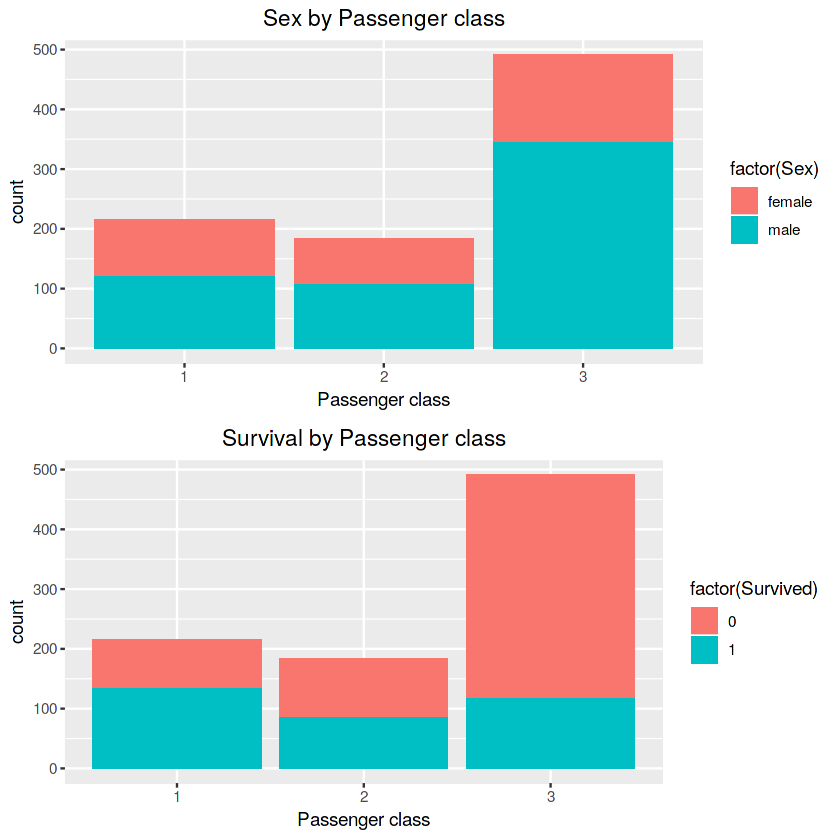

In [163]:
P3 <- ggplot(full_test[1:891,], aes(x = Pclass))+
  geom_bar(stat = "count", aes(fill = factor(Sex))) + 
  labs(x = "Passenger class")+
  ggtitle("Sex by Passenger class")+
  theme(plot.title = element_text(hjust = 0.5))


P4 <- ggplot(full_test[1:891,], aes(x = Pclass))+
  geom_bar(stat = "count", aes(fill = factor(Survived))) + 
  labs(x = "Passenger class")+
  ggtitle("Survival by Passenger class")+
  theme(plot.title = element_text(hjust = 0.5))

grid.arrange(P3, P4, nrow =2)

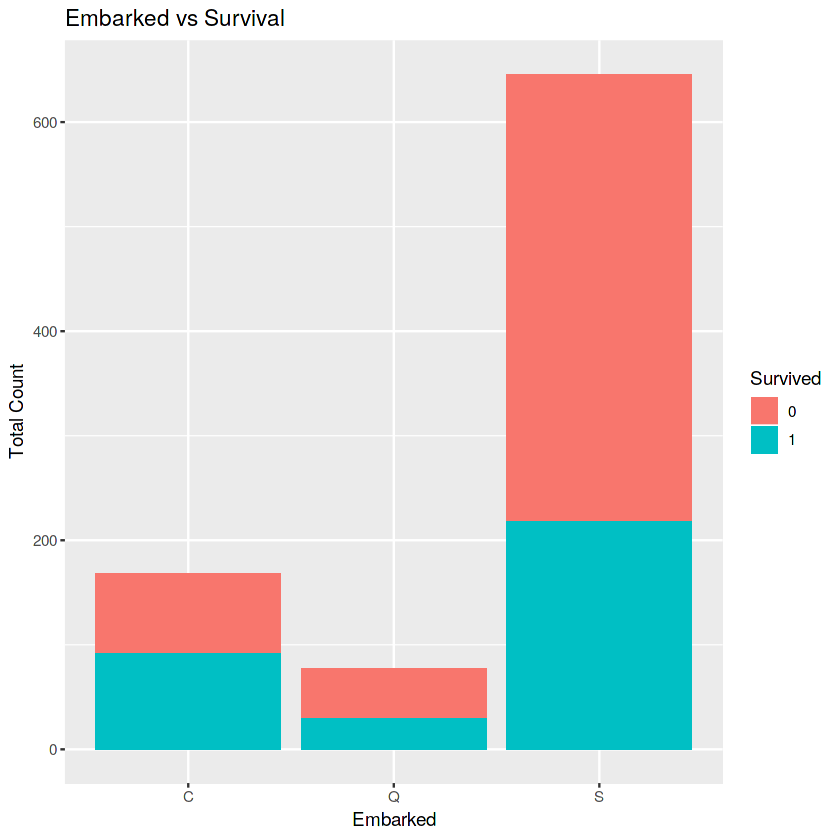

In [164]:
 ggplot(full_test[1:891,],aes(x = Embarked,fill=factor(Survived))) +
  geom_bar() +
  ggtitle("Embarked vs Survival") +
  xlab("Embarked") +
  ylab("Total Count") +
  labs(fill = "Survived") 

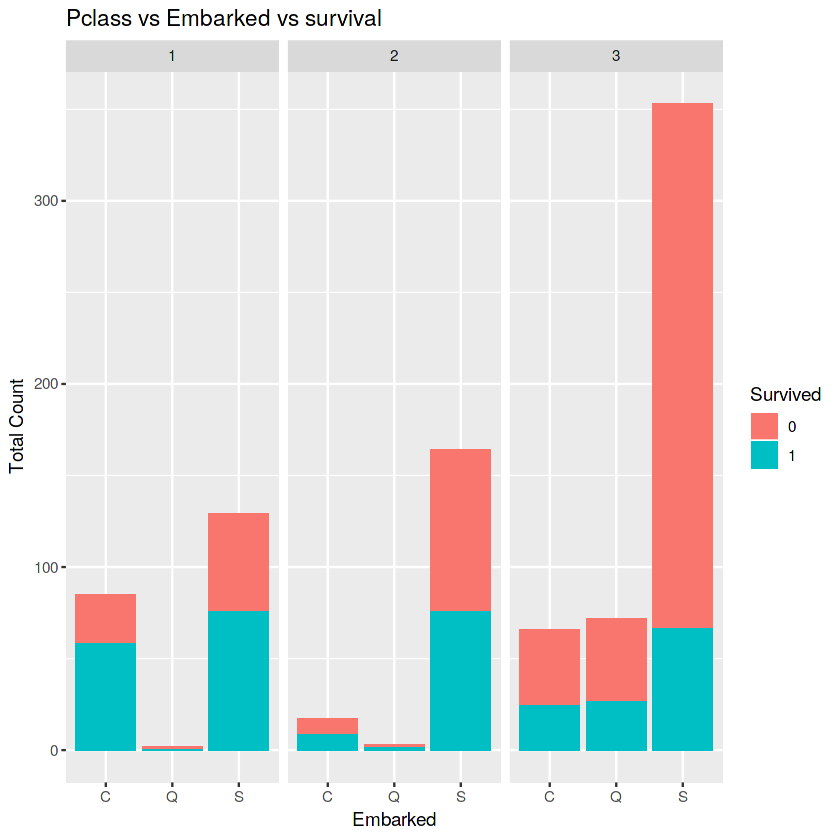

In [165]:
ggplot(full_test[1:891,], aes(x = Embarked, fill = Survived)) +
  geom_bar() +
  facet_wrap(~Pclass) + 
  ggtitle("Pclass vs Embarked vs survival") +
  xlab("Embarked") +
  ylab("Total Count") +
  labs(fill = "Survived")

In [166]:
full_test[which(full_test$Embarked == ""),]

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,FamilySized,Title,ticket.unique
<int>,<fct>,<fct>,<chr>,<fct>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<chr>,<dbl>


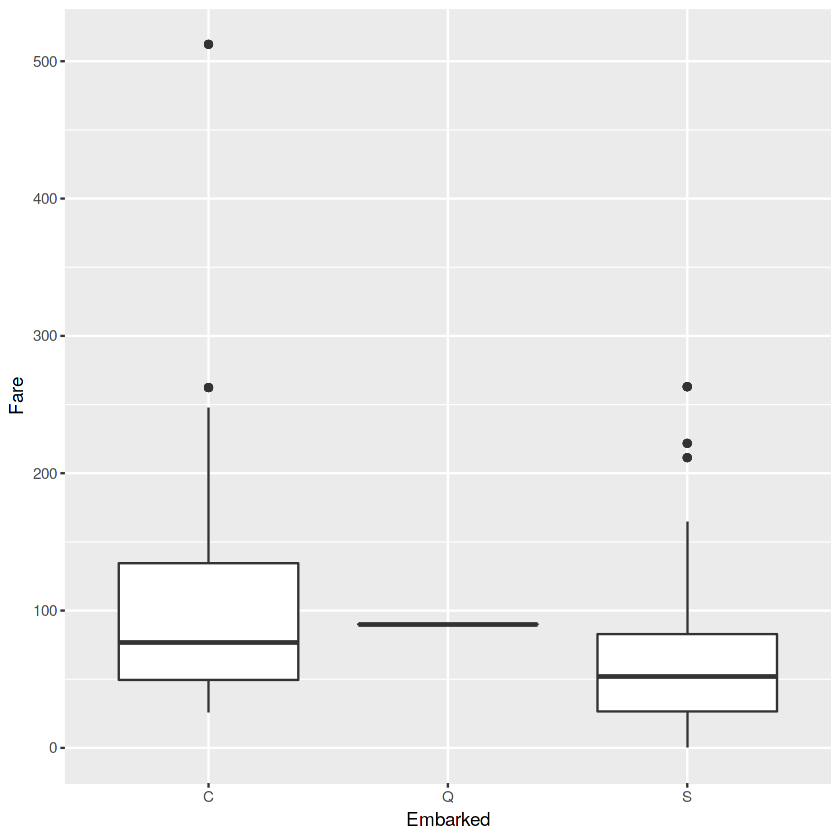

In [167]:
first_class <- subset(full_test, Pclass == 1)
ggplot(first_class, aes(x = Embarked, y = Fare)) +
  geom_boxplot() 

In [221]:
full_test$Embarked[c(480, 1248)] <- "C"

In [169]:
full_test[is.na(full_test$Fare),]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,FamilySized,Title,ticket.unique
,<int>,<fct>,<fct>,<chr>,<fct>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<chr>,<dbl>
1044,1044,NA,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NA,,S,1,Single,Mr,1


In [173]:
full_test$Fare[153] <- median(full_test[full_test$Pclass == '3' & full_test$Embarked == 'S', ]$Fare, na.rm = TRUE)


In [172]:
full_test$PassengerId <- as.factor(full_test$PassengerId)
full_test$Pclass <- as.factor(full_test$Pclass)
full_test$Sex <- as.factor(full_test$Sex)
full_test$Embarked <- as.factor(full_test$Embarked)
full_test$Title <- as.factor(full_test$Title)
full_test$Fam_size <- as.factor(full_test$FamilySize)

In [174]:
set.seed(129)

# Perform mice imputation, excluding certain less-than-useful variables:
mice_mod <- mice(full_test[, !names(full_test) %in% c('PassengerId','Name','Ticket','Cabin','Survived')], method='rf') 



 iter imp variable
  1   1  Age  Fare
  1   2  Age  Fare
  1   3  Age  Fare
  1   4  Age  Fare
  1   5  Age  Fare
  2   1  Age  Fare
  2   2  Age  Fare
  2   3  Age  Fare
  2   4  Age  Fare
  2   5  Age  Fare
  3   1  Age  Fare
  3   2  Age  Fare
  3   3  Age  Fare
  3   4  Age  Fare
  3   5  Age  Fare
  4   1  Age  Fare
  4   2  Age  Fare
  4   3  Age  Fare
  4   4  Age  Fare
  4   5  Age  Fare
  5   1  Age  Fare
  5   2  Age  Fare
  5   3  Age  Fare
  5   4  Age  Fare
  5   5  Age  Fare


Warning message:
“Number of logged events: 50”

In [175]:
full_test$Parent <- "Not a parent"
full_test$Parent[full_test$Sex == "male" & full_test$Parch >0 & full_test$Age >=18] <- "Father"
full_test$Parent[full_test$Sex == "female" & full_test$Parch >0 & full_test$Age >=18] <- "Mother"
full_test$Parent <- as.factor(full_test$Parent)


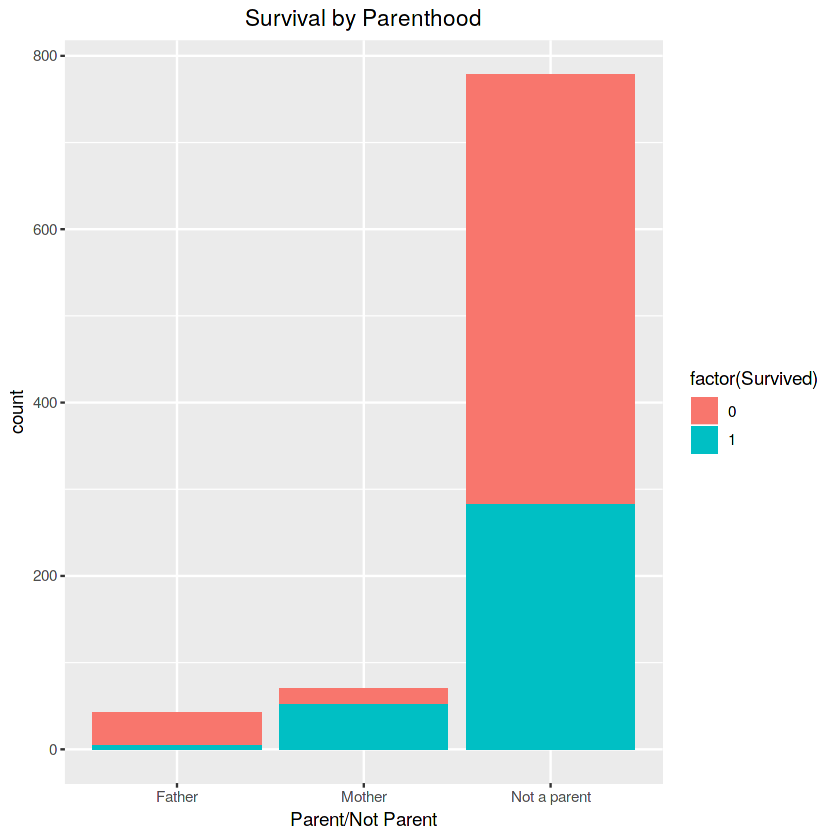

In [176]:
ggplot(full_test[1:891,], aes(x = Parent))+
  geom_bar(stat = "count", aes(fill = factor(Survived))) + 
  labs(x = "Parent/Not Parent")+
  ggtitle("Survival by Parenthood")+
  theme(plot.title = element_text(hjust = 0.5))

you poorer chances; in our adult males (>=18 years) the survival rate is 19 % for those who are not fathers, and 14 % for those who are. For mothers it’s 76 % and for adult females who are not mothers, it’s 74 %, so more or less the same. Looks like being a parent doesn’t change things drastically for the adults. Let’s see what the adult/child group reveals.

In [177]:
mean(full_test$Age, na.rm = TRUE)

[1] 29.88114

In [178]:
mice_output <- complete                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        (mice_mod)


ERROR: Error in UseMethod("complete_"): no applicable method for 'complete_' applied to an object of class "mids"


In [179]:
full_test$Age <- mice_output$Age
sum(is.na(full_test$Age))

[1] 0

In [180]:
full_test$Age_group <- 0
full_test$Age_group[full_test$Age < 18] <- "Child"
full_test$Age_group[full_test$Age > 17] <- "Adult"
table(full_test$Age_group, full_test$Survived)

       
          0   1
  Adult 482 274
  Child  67  68

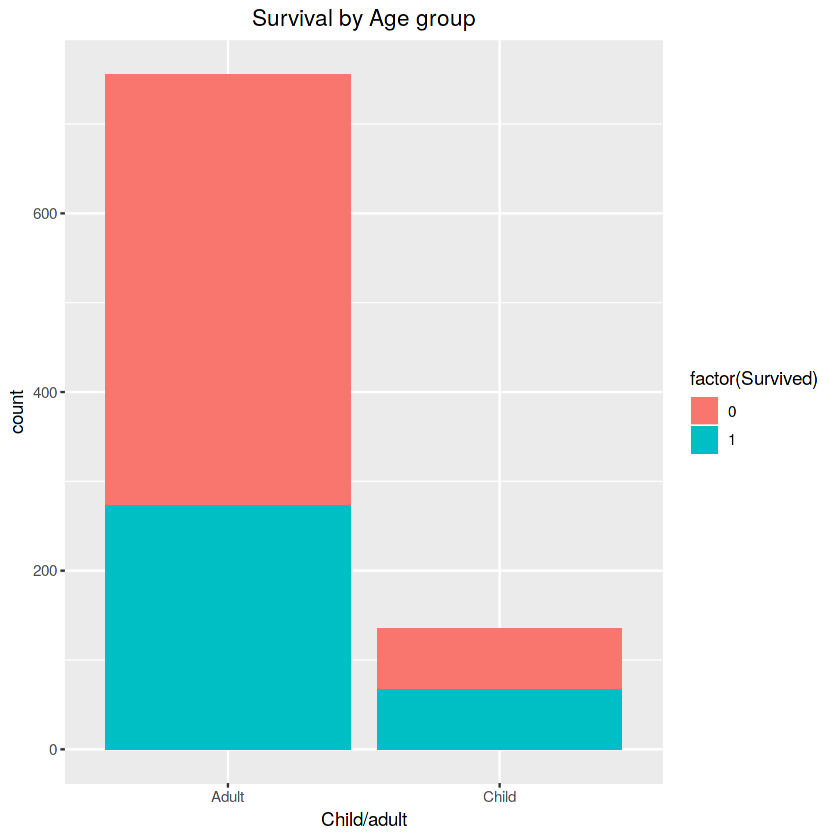

In [181]:
ggplot(full_test[1:891,], aes(x = Age_group))+
  geom_bar(stat = "count", aes(fill = factor(Survived))) + 
  labs(x = "Child/adult")+
  ggtitle("Survival by Age group")+
  theme(plot.title = element_text(hjust = 0.5))

In the child group, the survival rate is 52 %, whereas in the adult group it’s 52 %. Let’s look for some more clues; where there any children travelling alone?

In [182]:
table(full_test$Age_group[full_test$Fam_size == 1], full_test$Survived[full_test$Fam_size == 1])

       
          0   1
  Adult 356 150
  Child  18  13

Looks like there were 31 children travelling alone, of which 43 % survived, so slightly less than for children travelling with parents.

In [183]:
mean(full_test$Age[full_test$Age_group == "Child" & full_test$Fam_size == 1])

[1] 15.21277

In [184]:
min(full_test$Age[full_test$Age_group == "Child" & full_test$Fam_size == 1])


[1] 1

In [185]:
full_test[full_test$Age == 4 & full_test$Fam_size == 1,]


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,FamilySized,Title,ticket.unique,Fam_size,Parent,Age_group
<fct>,<fct>,<fct>,<chr>,<fct>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<chr>


In [186]:
full_test[full_test$Ticket == 36568,]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,FamilySized,Title,ticket.unique,Fam_size,Parent,Age_group
,<fct>,<fct>,<fct>,<chr>,<fct>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<chr>
719,719,0,3,"McEvoy, Mr. Michael",male,41,0,0,36568,15.5,,Q,1,Single,Mr,2,1,Not a parent,Adult
1092,1092,NA,3,"Murphy, Miss. Nora",female,22,0,0,36568,15.5,,Q,1,Single,Miss,2,1,Not a parent,Adult


Looking at $PaxTicket, we see that there are two passengers travelling on this ticket.

In [187]:
full_test$PaxTicket <- as.data.table(full_test)[, count := length(unique(Name)), by = Ticket][][,17]
full_test$PaxTicket <- unlist(full_test$PaxTicket)

full_test$Price_pax <- as.numeric(full_test$Fare) / as.numeric(full_test$PaxTicket)
str(full_test)

'data.frame':	1309 obs. of  21 variables:
 $ PassengerId  : Factor w/ 1309 levels "1","2","3","4",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Survived     : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass       : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name         : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex          : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age          : num  22 38 26 35 35 17 54 2 27 14 ...
 $ SibSp        : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch        : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket       : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare         : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin        : chr  "" "C85" "" "C123" ...
 $ Embarked     : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ FamilySize   : num  2 2 1 2 1 1 1 5 3 2 ...
 $ FamilySized  : Factor

In [188]:
 # Splitting the dataset into the Training set and Test set
train_original <- full_test[1:891, c("Survived","Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","Title","FamilySize")]
test_original <- full_test[892:1309, c("Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","Title","FamilySize")]

In [189]:
# Splitting the Training set into the Training set and Validation set
set.seed(789)
split = sample.split(train_original$Survived, SplitRatio = 0.8)
train = subset(train_original, split == TRUE)
test = subset(train_original, split == FALSE)

In [190]:
cor(train[,unlist(lapply(train,is.numeric))])

,Age,SibSp,Parch,Fare,FamilySize
Age,1.00000000,-0.3160317,-0.2297093,0.07267432,-0.3273401
SibSp,-0.31603168,1.0000000,0.4529568,0.15711528,0.9052506
Parch,-0.22970929,0.4529568,1.0000000,0.23615601,0.7888320
Fare,0.07267432,0.1571153,0.2361560,1.00000000,0.2208579
FamilySize,-0.32734008,0.9052506,0.7888320,0.22085786,1.0000000


In [191]:
ps = chisq.test(train$Pclass, train$Sex)$p.value
pe = chisq.test(train$Pclass, train$Embarked)$p.value
pt = chisq.test(train$Pclass, train$Title)$p.value
pf = chisq.test(train$Pclass, train$FamilySize)$p.value
se = chisq.test(train$Sex, train$Embarked)$p.value
st = chisq.test(train$Sex, train$Title)$p.value
sf = chisq.test(train$Sex, train$FamilySize)$p.value
et = chisq.test(train$Embarked, train$Title)$p.value
ef = chisq.test(train$Embarked, train$FamilySize)$p.value
tf = chisq.test(train$Title, train$FamilySize)$p.value
cormatrix = matrix(c(0, ps, pe, pt, pf,
                     ps, 0, se, st, sf,
                     pe, se, 0, et, ef,
                     pt, st, et, 0, tf,
                     pf, sf, ef, tf, 0), 
                   5, 5, byrow = TRUE)
row.names(cormatrix) = colnames(cormatrix) = c("Pclass", "Sex", "Embarked", "Title", "FamilySize")
cormatrix

Warning message in chisq.test(train$Pclass, train$Title):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(train$Pclass, train$FamilySize):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(train$Sex, train$FamilySize):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(train$Embarked, train$Title):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(train$Embarked, train$FamilySize):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(train$Title, train$FamilySize):
“Chi-squared approximation may be incorrect”

,Pclass,Sex,Embarked,Title,FamilySize
Pclass,0.000000e+00,2.532566e-03,1.745860e-22,7.673946e-11,2.497061e-08
Sex,2.532566e-03,0.000000e+00,1.727779e-02,4.702645e-149,1.195898e-14
Embarked,1.745860e-22,1.727779e-02,0.000000e+00,5.359800e-05,2.184642e-05
Title,7.673946e-11,4.702645e-149,5.359800e-05,0.000000e+00,8.166611e-51
FamilySize,2.497061e-08,1.195898e-14,2.184642e-05,8.166611e-51,0.000000e+00


I use Chi Square test to test the independence of factors/categorical features. Since all the p-values < 0.05, we reject each Ho:Two factors are independent at 5% significance level and indeed at any reasonable level of significance. This violates the independence assumption of features and can be confirmed that multicollinearity does exist among factors. I will deal with this issue down the road and now go ahead and fit the logistic regression model.

In [192]:
classifier = glm(Survived ~ ., family = binomial(link='logit'), data = train)

# Choosing the best model by AIC in a Stepwise Algorithm
# The step() function iteratively removes insignificant predictor variables from the model.
classifier <- step(classifier)

Start:  AIC=617.34
Survived ~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + 
    Title + FamilySize


Step:  AIC=617.34
Survived ~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + 
    Title

           Df Deviance    AIC
- Fare      1   589.55 615.55
- Embarked  2   592.57 616.57
- Parch     1   590.97 616.97
<none>          589.34 617.34
- Sex       1   596.02 622.02
- Age       1   597.04 623.04
- SibSp     1   608.20 634.20
- Title     4   631.80 651.80
- Pclass    2   639.81 663.81

Step:  AIC=615.55
Survived ~ Pclass + Sex + Age + SibSp + Parch + Embarked + Title

           Df Deviance    AIC
- Parch     1   591.00 615.00
- Embarked  2   593.06 615.06
<none>          589.55 615.55
- Sex       1   596.20 620.20
- Age       1   597.50 621.50
- SibSp     1   608.23 632.23
- Title     4   631.80 649.80
- Pclass    2   667.70 689.70

Step:  AIC=615
Survived ~ Pclass + Sex + Age + SibSp + Embarked + Title

           Df Deviance    AIC
- Embarked  2   594.56 614.56
<non

In [193]:
summary(classifier)


Call:
glm(formula = Survived ~ Pclass + Sex + Age + SibSp + Title, 
    family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4903  -0.6107  -0.3639   0.5672   2.7326  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      19.68971  574.89909   0.034 0.972679    
Pclass2          -1.38506    0.31635  -4.378 1.20e-05 ***
Pclass3          -2.58775    0.30117  -8.592  < 2e-16 ***
Sexmale         -15.59655  574.89876  -0.027 0.978357    
Age              -0.02652    0.00945  -2.806 0.005016 ** 
SibSp            -0.60681    0.12976  -4.676 2.92e-06 ***
TitleMiss       -15.97509  574.89901  -0.028 0.977832    
TitleMr          -3.25868    0.57898  -5.628 1.82e-08 ***
TitleMrs        -15.47187  574.89908  -0.027 0.978530    
TitleRare title  -2.77092    0.83350  -3.324 0.000886 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family t

In [194]:
vif(classifier)

,GVIF,Df,GVIF^(1/(2*Df))
Pclass,1.565537e+00,2,1.118577
Sex,7.641397e+06,1,2764.307640
Age,1.830087e+00,1,1.352807
SibSp,1.553570e+00,1,1.246423
Title,1.468366e+07,4,7.867818


In [195]:
classifier = glm(Survived ~ . -Sex, family = binomial(link='logit'), data = train)

# Choosing the best model by AIC in a Stepwise Algorithm
# The step() function iteratively removes insignificant features from the model.
classifier <- step(classifier)

Start:  AIC=622.02
Survived ~ (Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + 
    Title + FamilySize) - Sex


Step:  AIC=622.02
Survived ~ Pclass + Age + SibSp + Parch + Fare + Embarked + Title

           Df Deviance    AIC
- Fare      1   596.20 620.20
- Embarked  2   599.00 621.00
- Parch     1   597.65 621.65
<none>          596.02 622.02
- Age       1   604.71 628.71
- SibSp     1   615.77 639.77
- Pclass    2   647.39 669.39
- Title     4   796.89 814.89

Step:  AIC=620.2
Survived ~ Pclass + Age + SibSp + Parch + Embarked + Title

           Df Deviance    AIC
- Embarked  2   599.43 619.43
- Parch     1   597.67 619.67
<none>          596.20 620.20
- Age       1   605.17 627.17
- SibSp     1   615.82 637.82
- Pclass    2   675.94 695.94
- Title     4   797.29 813.29

Step:  AIC=619.43
Survived ~ Pclass + Age + SibSp + Parch + Title

         Df Deviance    AIC
- Parch   1   600.94 618.94
<none>        599.43 619.43
- Age     1   609.23 627.23
- SibSp   1   621.38 639.38


In [196]:
summary(classifier)


Call:
glm(formula = Survived ~ Pclass + Age + SibSp + Title, family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5104  -0.6143  -0.3619   0.5929   2.7405  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      4.160011   0.653058   6.370 1.89e-10 ***
Pclass2         -1.422390   0.312420  -4.553 5.29e-06 ***
Pclass3         -2.618394   0.300246  -8.721  < 2e-16 ***
Age             -0.027935   0.009389  -2.975  0.00293 ** 
SibSp           -0.617094   0.129638  -4.760 1.93e-06 ***
TitleMiss       -0.379856   0.538443  -0.705  0.48052    
TitleMr         -3.256813   0.580682  -5.609 2.04e-08 ***
TitleMrs         0.143326   0.594098   0.241  0.80936    
TitleRare title -2.090404   0.757318  -2.760  0.00578 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 949.90  on 712  degrees of fre

In [197]:
vif(classifier)

,GVIF,Df,GVIF^(1/(2*Df))
Pclass,1.589144,2,1.122770
Age,1.823408,1,1.350336
SibSp,1.548458,1,1.244370
Title,2.221774,4,1.104937


vif function delivers very high Generalized Variable Inflation Factor (GVIF) for factors Sex and Title. This confirmes the multicollinearity between factors Sex and Title.

**How to handle multicollinearity?**

We want to make our model robust. I omit the factor Sex from the logistic regression model because it exhibits a high degree of multicollinearity.

In [198]:
durbinWatsonTest(classifier)

 lag Autocorrelation D-W Statistic p-value
   1      0.03142981      1.936734   0.394
 Alternative hypothesis: rho != 0

The standard errors are in a reasonable range. GVIF values are all less than 5. Furthermore, since Durbin-Watson test results with D-W Statistic 1.936 and p-value > 0.394, we do not reject Ho:Residuals are not autocorrelated. Hence, we can conclude there is sufficient evidence to say residuals are not autocorrelated. Hooray! The assumptions are checked and they are passed.

According to the best model, the features Pclass, Age, Title and FamilySize significantly contribute to the model in predicting survival. We will see how well the model predicts on new data in the validation set.

In [199]:
prob_pred = predict(classifier, type = 'response', newdata = test)
y_pred = ifelse(prob_pred > 0.5, 1, 0)

# Checking the prediction accuracy
table(test$Survived, y_pred > 0.5) # Confusion matrix

   
    FALSE TRUE
  0   100   10
  1    16   52

In [200]:
error <- mean(test$Survived != y_pred) # Misclassification error
paste('Accuracy',round(1-error,4))

[1] "Accuracy 0.8539"

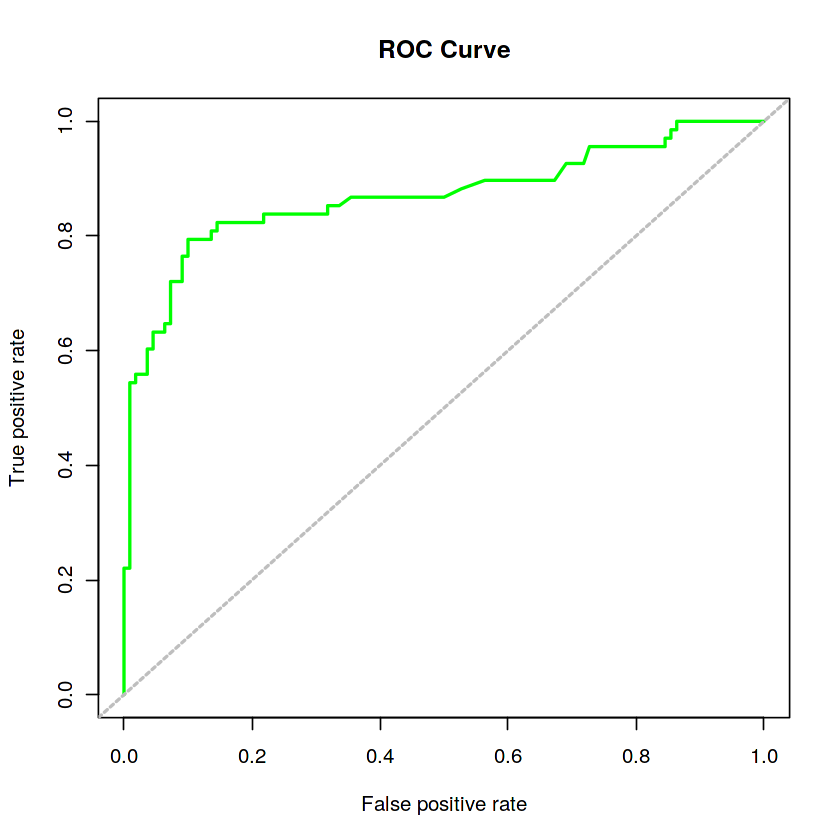

In [201]:
fitpred = prediction(prob_pred, test$Survived)
fitperf = performance(fitpred,"tpr","fpr")
plot(fitperf,col="green",lwd=2,main="ROC Curve")
abline(a=0,b=1,lwd=2,lty=2,col="gray")

The ROC (Receiver Operating Characteristics) curve is a graphical representation of the performnace of the classifier and it shows the performance of our model rises well above the diagonal line. This indicates that our logistic regression model performs better than just a random guess. The logistic regression model delivers a whooping 0.8539 accuracy interms of predicting the survival.



**Support Vector Machines**

Secondly, I use Support Vector Machines (SVM) for classification. In order to use SVM, we need to remember to do one thing - Feature Scaling! Because the SVM classifier predicts the class of a given test observation by identifying the observations that are nearest to it, the scale of the variables matters.

In [202]:
paste('Age variance: ',var(train$Age),', SibSp variance: ',var(train$SibSp),', Parch variance: ',var(train$Parch),', Fare variance: ',var(train$Fare))

[1] "Age variance:  198.169077337016 , SibSp variance:  1.26512441495816 , Parch variance:  0.604594449784894 , Fare variance:  2291.51426667939"

In [203]:
standardized.train = cbind(select(train, Survived, Pclass, Sex, SibSp, Parch, Embarked, Title, FamilySize), Age = scale(train$Age), Fare = scale(train$Fare))
paste('Age variance: ',var(standardized.train$Age),', Fare variance: ',var(standardized.train$Fare))

[1] "Age variance:  1 , Fare variance:  1"

In [204]:
standardized.test = cbind(select(test, Survived, Pclass, Sex, SibSp, Parch, Embarked, Title, FamilySize), Age = scale(test$Age), Fare = scale(test$Fare))
paste('Age variance: ',var(standardized.test$Age),', Fare variance: ',var(standardized.test$Fare))

[1] "Age variance:  1 , Fare variance:  1"

Now that we have done the feature scaling, we can fit SVM to predict survival. First I fit a linear SVM.

In [205]:
classifier = svm(Survived ~ .,
                 data = standardized.train,
                 type = 'C-classification',
                 kernel = 'linear')

y_pred = predict(classifier, newdata = standardized.test[,-which(names(standardized.test)=="Survived")])


table(test$Survived, y_pred) 

   y_pred
      0   1
  0 102   8
  1  16  52

In [206]:
error <- mean(test$Survived != y_pred) # Misclassification error
paste('Accuracy',round(1-error,4))

[1] "Accuracy 0.8652"

The linear model accuracy is 0.8764. Let’s fit a non-linear radial kernel and see whether the accuracy will be improved.

In [207]:
classifier = svm(Survived ~ .,
                 data = standardized.train,
                 type = 'C-classification',
                 kernel = 'radial')


y_pred = predict(classifier, newdata = standardized.test[,-which(names(standardized.test)=="Survived")])


table(test$Survived, y_pred)

   y_pred
      0   1
  0 105   5
  1  16  52

In [208]:
error <- mean(test$Survived != y_pred) # Misclassification error
paste('Accuracy',round(1-error,4))

[1] "Accuracy 0.882"

The accuracy has been imporved by 0.2% to 0.882.Also, note that both linear SVM and non-linear SVM accuracies are higher than the accuracy for logistic regression model.



In [211]:
tune.results <- tune(svm,
                     Survived ~ .,
                     data = standardized.train,
                     kernel='radial',
                     ranges=list(cost=2^(-2:2), gamma=2^(-6:-2)))
summary(tune.results)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
    2 0.125

- best performance: 0.1751565 

- Detailed performance results:
   cost    gamma     error dispersion
1  0.25 0.015625 0.2089984 0.05486974
2  0.50 0.015625 0.2076291 0.05824161
3  1.00 0.015625 0.1991393 0.05189025
4  2.00 0.015625 0.1907473 0.05669481
5  4.00 0.015625 0.1879304 0.05385815
6  0.25 0.031250 0.1963419 0.05073551
7  0.50 0.031250 0.1949139 0.05292765
8  1.00 0.031250 0.1865219 0.04905777
9  2.00 0.031250 0.1851135 0.05486616
10 4.00 0.031250 0.1893192 0.05540679
11 0.25 0.062500 0.1879108 0.04529049
12 0.50 0.062500 0.1851135 0.04981265
13 1.00 0.062500 0.1879108 0.04904190
14 2.00 0.062500 0.1851330 0.04856579
15 4.00 0.062500 0.1892606 0.06250069
16 0.25 0.125000 0.1892997 0.04167499
17 0.50 0.125000 0.1865023 0.04711255
18 1.00 0.125000 0.1864632 0.06068227
19 2.00 0.125000 0.1751565 0.06224827
20 4.00 0.125000 0.1807121 0.06745526
21 0.25 0.250000 0.

In [210]:
classifier = svm(Survived ~ .,
                 data = standardized.train,
                 type = 'C-classification',
                 kernel = 'radial',
                 cost = 4,
                 gamma = 0.125)
y_pred = predict(classifier, newdata = standardized.test[,-which(names(standardized.test)=="Survived")])

table(test$Survived, y_pred) 

   y_pred
      0   1
  0 104   6
  1  23  45

In [212]:
error <- mean(test$Survived != y_pred) # Misclassification error
paste('Accuracy',round(1-error,4))

[1] "Accuracy 0.8371"

The accuracy went down to 0.8371. We were not able to improve our model. Infact, the best non-linear SVM was already a good model with accuracy 0.8820. I retain that model as my best non-linear SVM model with cost=1 and gamma=0.0625.



**Decision Tree**

As we all know, Random Forest is a more powerful algorithm over just a single tree. However, the Decision Tree classification preserve the interpretability which the random forest algorithm lacks.

The Decision Tree does not require feature scaling. Let’s fit a decision tree model to our training data.

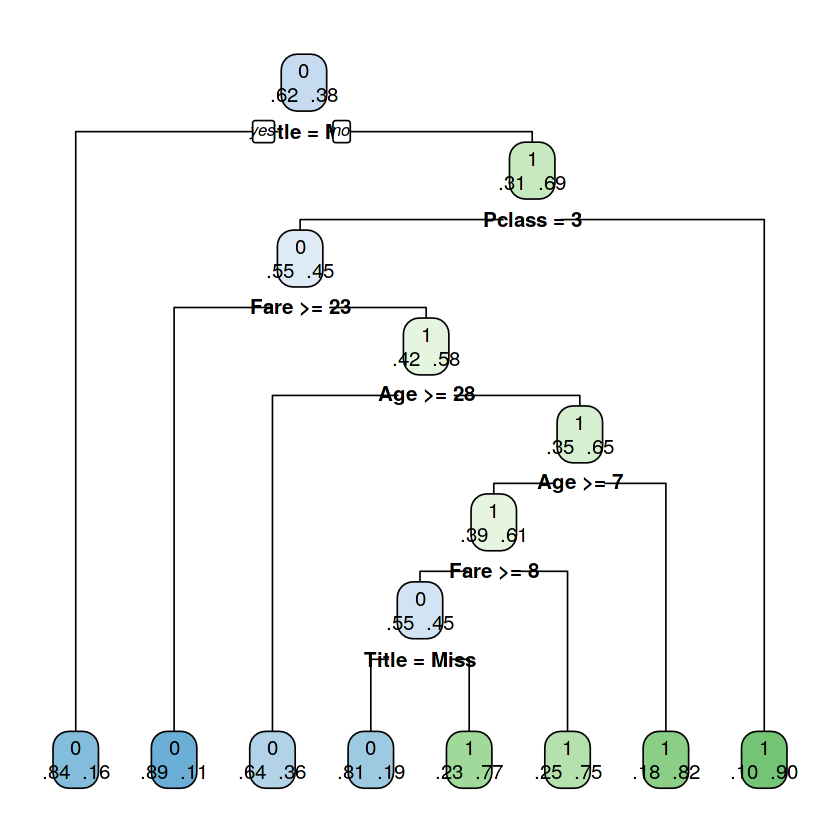

In [213]:
classifier = rpart(Survived ~ ., data = train, method = 'class')
rpart.plot(classifier, extra=4)

The single tree uses five features Title, Pclass, Fare, Age and FamilySize for classification. Let’s see how well our model performs with the data in the validation set.



In [214]:
y_pred = predict(classifier, newdata = test[,-which(names(test)=="Survived")], type='class')
table(test$Survived, y_pred)

   y_pred
      0   1
  0 102   8
  1  24  44

In [215]:
error <- mean(test$Survived != y_pred) 
paste('Accuracy',round(1-error,4))

[1] "Accuracy 0.8202"

Accuracy of a single tree is 0.8202. Overfitting can easily occur in Decision Tree classification. We can idenfity that evaluating the model using k-Fold Cross Validation. Or we might be able to improve the model. Let’s do 10-fold cross validation to find out whether we could improve the model.

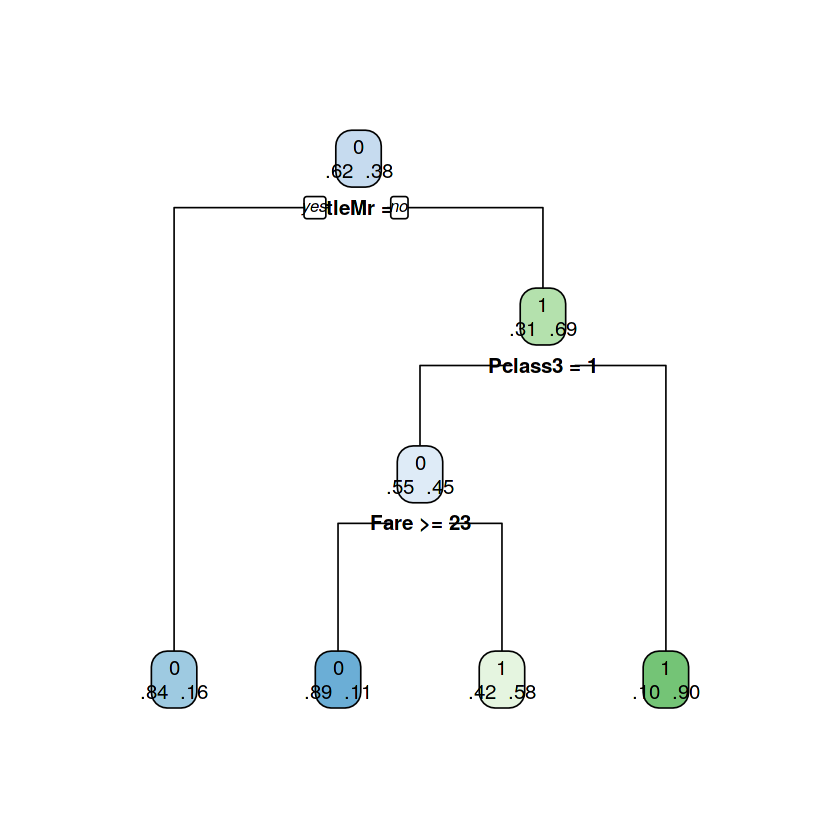

In [216]:
set.seed(789)
folds = createMultiFolds(train$Survived, k = 10, times = 5)
control <- trainControl(method = "repeatedcv", index = folds)
classifier_cv <- train(Survived ~ ., data = train, method = "rpart", trControl = control)
rpart.plot(classifier_cv$finalModel, extra=4)

In [217]:
y_pred = predict(classifier_cv, newdata = test[,-which(names(test)=="Survived")])

table(test$Survived, y_pred)

   y_pred
     0  1
  0 99 11
  1 17 51

In [219]:
error <- mean(test$Survived != y_pred) # Misclassification error
paste('Accuracy',round(1-error,4))

[1] "Accuracy 0.8427"

We were able to improve the model after 10-fold cross validation. The accuracy has been improved to 0.8427 but note the improved model uses only three features Title, Pclass and Fare for classification.